<a href="https://colab.research.google.com/github/RicardoMourao-py/CNN-ALZHEIMER-CLASSIFICATION/blob/main/shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import module
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# set seed
torch.manual_seed(0)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# install shap
# !pip install shap
import shap
# check pytorch version
print("PyTorch version:", torch.__version__)
# use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

PyTorch version: 2.1.0+cu118
device: cuda


In [ ]:
# !unzip shap_dataset.zip

In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):

    def __getitem__(self, index):

        img, label = super(ImageFolderWithPaths, self).__getitem__(index)

        path = self.imgs[index][0]

        return (img, label ,path)

# set batch size
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
# set transformation for training and validation
transform_train = transforms.Compose([
                transforms.Resize(size = (224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5946, 0.5732, 0.5126), std=(0.2671, 0.2737, 0.3058)) # use calculated mean and std
                ])
TRAIN_DATA_ROOT = "./shap_dataset/train"
train_dataset = datasets.ImageFolder(TRAIN_DATA_ROOT, transform=transform_train)

VAL_DATA_ROOT = "./shap_dataset/test"
val_dataset = datasets.ImageFolder(VAL_DATA_ROOT, transform=transform_train)
# define data loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=TRAIN_BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=4)
test_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=VAL_BATCH_SIZE,
                                          shuffle=False,
                                          num_workers=4)

# set transformation for SHAP visualization
base_transform = transforms.Compose([
                 transforms.Resize(size = (224, 224)),
                 transforms.ToTensor()
                 ])
# set dataset
base_dataset = ImageFolderWithPaths(TRAIN_DATA_ROOT, transform=base_transform)
# define data loader
base_loader = torch.utils.data.DataLoader(base_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=4)

In [ ]:
for inputs, labels, paths in base_loader:
    print(inputs.shape, labels, paths)
    break

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


torch.Size([64, 3, 224, 224]) tensor([0, 2, 2, 3, 2, 0, 0, 0, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2,
        3, 2, 2, 3, 3, 2, 0, 3, 2, 2, 3, 2, 3, 0, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3,
        2, 3, 2, 0, 3, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2]) ('./shap_dataset/train/MildDemented/mildDem378.jpg', './shap_dataset/train/NonDemented/nonDem1089.jpg', './shap_dataset/train/NonDemented/nonDem1659.jpg', './shap_dataset/train/VeryMildDemented/verymildDem1131.jpg', './shap_dataset/train/NonDemented/nonDem1265.jpg', './shap_dataset/train/MildDemented/mildDem496.jpg', './shap_dataset/train/MildDemented/mildDem420.jpg', './shap_dataset/train/MildDemented/mildDem492.jpg', './shap_dataset/train/NonDemented/nonDem2279.jpg', './shap_dataset/train/VeryMildDemented/verymildDem599.jpg', './shap_dataset/train/NonDemented/nonDem2475.jpg', './shap_dataset/train/VeryMildDemented/verymildDem1517.jpg', './shap_dataset/train/NonDemented/nonDem1360.jpg', './shap_dataset/train/NonDemented/nonDem2480.jpg', './sh

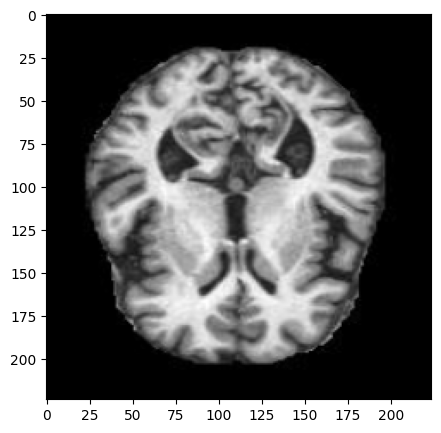

In [ ]:
images, targets, path = next(iter(base_loader))
images = images[0]
grid_img = torchvision.utils.make_grid(images)
plt.figure(figsize = (5,5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [ ]:
path

('./shap_dataset/train/NonDemented/nonDem545.jpg',
 './shap_dataset/train/NonDemented/nonDem1209.jpg',
 './shap_dataset/train/NonDemented/nonDem1385.jpg',
 './shap_dataset/train/NonDemented/nonDem128.jpg',
 './shap_dataset/train/MildDemented/mildDem495.jpg',
 './shap_dataset/train/NonDemented/nonDem2323.jpg',
 './shap_dataset/train/NonDemented/nonDem1888.jpg',
 './shap_dataset/train/NonDemented/nonDem826.jpg',
 './shap_dataset/train/VeryMildDemented/verymildDem226.jpg',
 './shap_dataset/train/VeryMildDemented/verymildDem1373.jpg',
 './shap_dataset/train/NonDemented/nonDem105.jpg',
 './shap_dataset/train/NonDemented/nonDem861.jpg',
 './shap_dataset/train/NonDemented/nonDem1140.jpg',
 './shap_dataset/train/VeryMildDemented/verymildDem1667.jpg',
 './shap_dataset/train/MildDemented/mildDem425.jpg',
 './shap_dataset/train/VeryMildDemented/verymildDem536.jpg',
 './shap_dataset/train/NonDemented/nonDem972.jpg',
 './shap_dataset/train/VeryMildDemented/verymildDem1639.jpg',
 './shap_dataset/tra

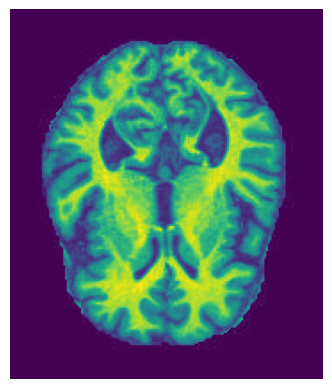

In [ ]:
# Atributo 'imgs' do conjunto de dados contém uma lista de tuplas (caminho, rótulo)
img_paths = base_dataset.imgs
caminho_da_imagem = path[0]
imagem = mpimg.imread(caminho_da_imagem)

# Plota a imagem
plt.imshow(imagem)
plt.axis('off')
plt.show()

In [ ]:
base_dataset.class_to_idx

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [ ]:
# calculate mean and std for each channel
R = 0
G = 0
B = 0
R_2 = 0
G_2 = 0
B_2 = 0

for i in range(1019):
  R += torch.sum(train_dataset[i][0][0])
  G += torch.sum(train_dataset[i][0][1])
  B += torch.sum(train_dataset[i][0][2])
  R_2 += torch.sum(torch.square(train_dataset[i][0][0]))
  G_2 += torch.sum(torch.square(train_dataset[i][0][1]))
  B_2 += torch.sum(torch.square(train_dataset[i][0][2]))

R_mean = R/(224*224)/1019
G_mean = G/(224*224)/1019
B_mean = B/(224*224)/1019

R_2_mean = R_2/(224*224)/1019
G_2_mean = G_2/(224*224)/1019
B_2_mean = B_2/(224*224)/1019

R_std = np.sqrt(R_2_mean - np.square(R_mean))
G_std = np.sqrt(G_2_mean - np.square(G_mean))
B_std = np.sqrt(B_2_mean - np.square(B_mean))

print(R_mean, G_mean, B_mean)
print(R_std, G_std, B_std)

tensor(-1.2040) tensor(-1.0968) tensor(-0.7835)
tensor(1.1864) tensor(1.1577) tensor(1.0362)


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


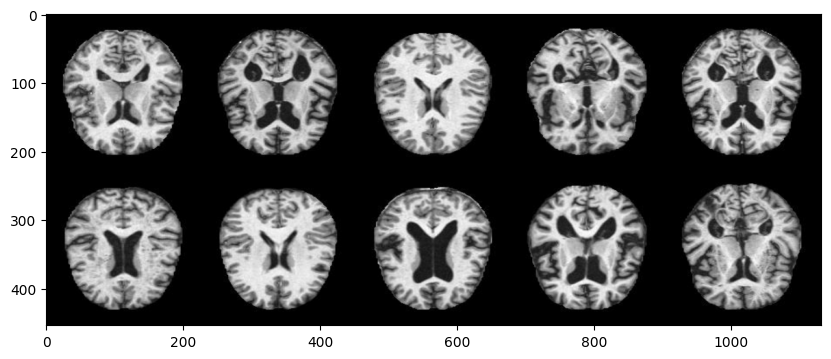

In [ ]:
# visualize iamge
images, targets, path = next(iter(base_loader))
images = images[:10]
targets = targets[:10]
# Plot grid of images
grid_img = torchvision.utils.make_grid(images, 5)

plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [ ]:
# define a neural network
class Simple_NN(nn.Module):
    def __init__(self):
        super(Simple_NN, self).__init__()
        self.conv_sec = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.fc_sec = nn.Sequential(
            nn.Linear(16*54*54, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 4)
        )

    def forward(self, x):
        conv_out = self.conv_sec(x)
        flatten_out = conv_out.view(-1, 16*54*54)
        fc_out = self.fc_sec(flatten_out)

        return fc_out
# instantiate the network and add to device
model = Simple_NN().to(device)

In [ ]:
# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
# total number of training epochs
EPOCHS = 15
# define lists for tracking performance
train_acc = []
val_acc = []
train_loss_list = []
val_loss_list = []

print("==> Training starts!")
print("="*50)

for i in range(0, EPOCHS):
    # switch to train mode
    model.train()
    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0
    train_loss = 0 # track training loss if you want
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # compute the output and loss
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # zero the gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # apply gradient and update the weights
        optimizer.step()
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        total_examples += targets.shape[0]
        train_loss += loss
        correct_examples += correct.item()

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_loss_list.append(float(avg_loss.detach().cpu().numpy()))
    train_acc.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # switch to eval mode
    model.eval()
    total_examples = 0
    correct_examples = 0
    val_loss = 0 # again, track the validation loss if you want
    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            total_examples += targets.shape[0]
            val_loss += loss
            correct_examples += correct.item()

    avg_loss = val_loss / len(test_loader)
    avg_acc = correct_examples / total_examples
    val_loss_list.append(float(avg_loss.detach().cpu().numpy()))
    val_acc.append(avg_acc)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))


==> Training starts!
Epoch 0:
Training loss: 1.0023, Training accuracy: 0.5095
Validation loss: 1.9880, Validation accuracy: 0.5004
Epoch 1:
Training loss: 0.8446, Training accuracy: 0.5983
Validation loss: 2.0864, Validation accuracy: 0.5035
Epoch 2:
Training loss: 0.6675, Training accuracy: 0.7001
Validation loss: 4.2921, Validation accuracy: 0.3503
Epoch 3:
Training loss: 0.9800, Training accuracy: 0.5807
Validation loss: 2.4620, Validation accuracy: 0.5066
Epoch 4:
Training loss: 0.9253, Training accuracy: 0.6050
Validation loss: 1.6891, Validation accuracy: 0.3276
Epoch 5:
Training loss: 0.9531, Training accuracy: 0.5534
Validation loss: 1.3084, Validation accuracy: 0.5293
Epoch 6:
Training loss: 0.6696, Training accuracy: 0.7040
Validation loss: 1.5410, Validation accuracy: 0.5637
Epoch 7:
Training loss: 0.4573, Training accuracy: 0.8053
Validation loss: 1.9226, Validation accuracy: 0.3714
Epoch 8:
Training loss: 0.3387, Training accuracy: 0.8555
Validation loss: 2.0791, Validati

In [ ]:
batch = next(iter(base_loader))
images, labels, path = batch

In [ ]:
len(images)

64

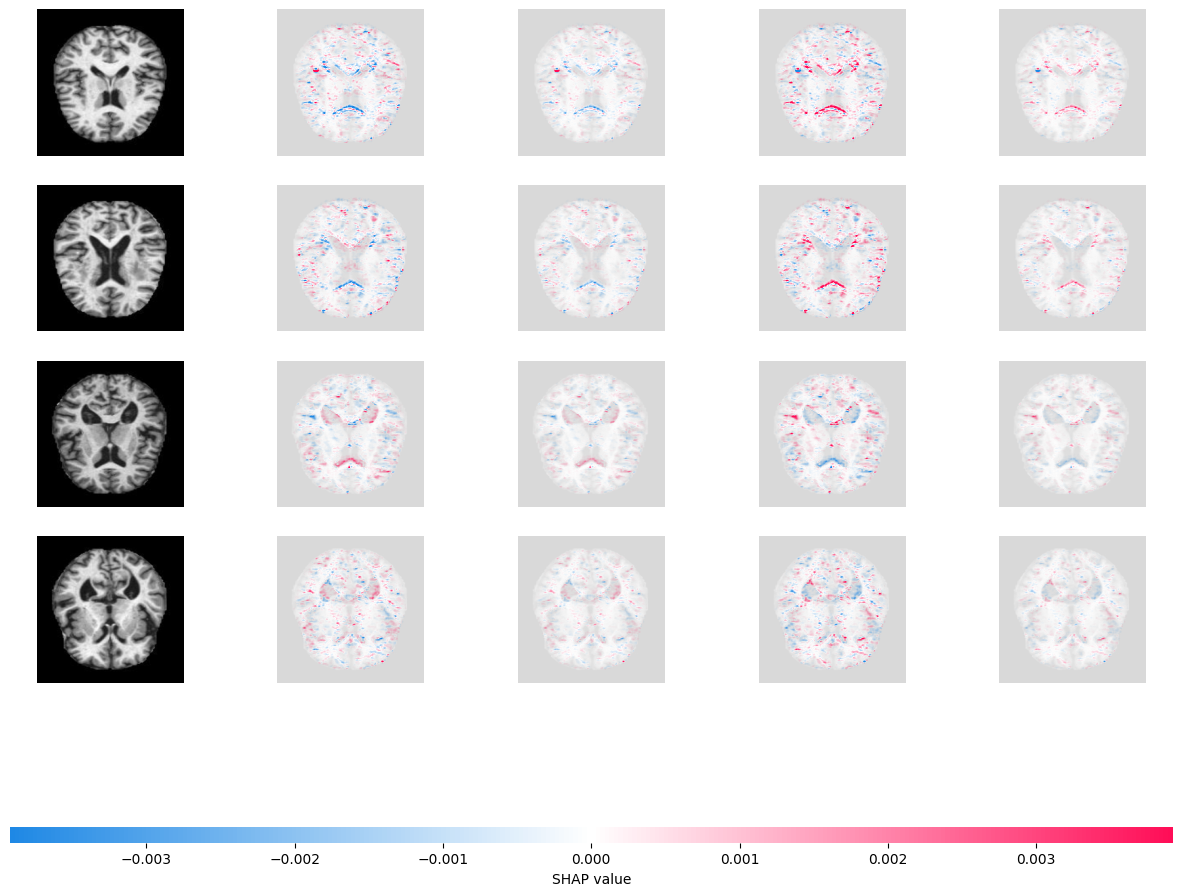

In [ ]:
background = images[:60].to(device)
test_images = images[60:64].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, test_numpy)

In [ ]:
path[60:64]

('./shap_dataset/train/NonDemented/nonDem2173.jpg',
 './shap_dataset/train/NonDemented/nonDem2274.jpg',
 './shap_dataset/train/NonDemented/nonDem1245.jpg',
 './shap_dataset/train/NonDemented/nonDem321.jpg')

<Figure size 1000x5000 with 0 Axes>

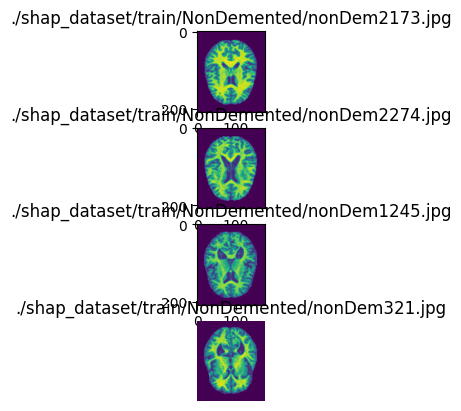

In [ ]:
caminho_da_imagem = path[60:64]
imagem1 = mpimg.imread(path[60])
imagem2 = mpimg.imread(path[61])
imagem3 = mpimg.imread(path[62])
imagem4 = mpimg.imread(path[63])

# Plota a imagem
plt.figure(figsize = (10,50))
fig, axs = plt.subplots(4)
axs[0].imshow(imagem1)
axs[0].set_title(f'{path[60]}')
axs[1].imshow(imagem2)
axs[1].set_title(f'{path[61]}')
axs[2].imshow(imagem3)
axs[2].set_title(f'{path[62]}')
axs[3].imshow(imagem4)
axs[3].set_title(f'{path[63]}')
plt.axis('off')
plt.show()